<div style="width: 100%; overflow: hidden;">
    <a href="http://www.uc.pt/fctuc/dei/">
    <div style="display: block;margin-left: auto;margin-right: auto; width: 50%;"><img src="https://eden.dei.uc.pt/~naml/images_ecos/dei25.png"  /></div>
    </a>
</div>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
from torchvision import transforms
from sklearn.metrics import confusion_matrix, f1_score
from torch.functional import F


### Introduction

In this class, we'll try to solve some image classification problems with Artificial Neural Networks. We'll start by using a fully connected network and see how well it does.



In order to do this, we need a problem. We'll start with MNIST, a popular benchmark problem whose goal is to recognise hand-written digits. The samples are gray-scale images and the targets are one of 10 classes (one for each digit).

Let's start by importing the dataset from torchvision.

100.0%
100.0%
100.0%
100.0%


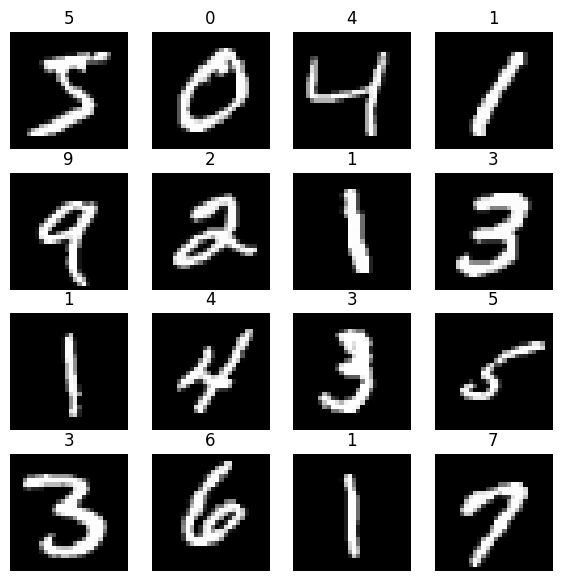

In [4]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

X_train = mnist_trainset.data.numpy()
y_train = mnist_trainset.targets.numpy()
X_test = mnist_testset.data.numpy()
y_test = mnist_testset.targets.numpy()
    
plt.figure(figsize=(7, 7))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(y_train[i])
    plt.axis("off")




As you can see, the images are gray-scale. However, for the purposes of this task, we can make our model's life easier by binarising these images.

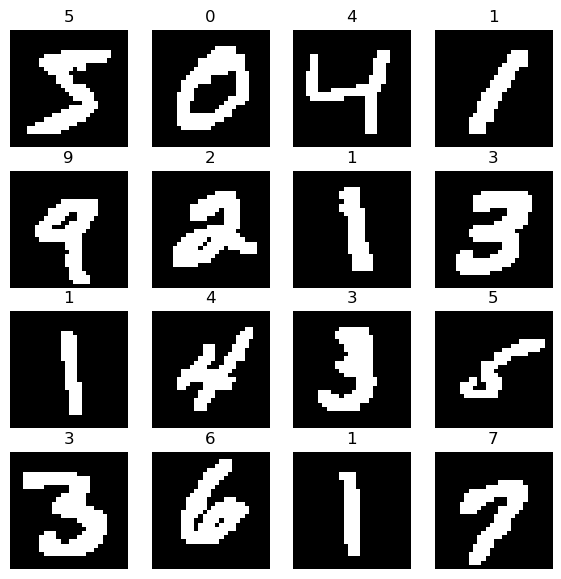

In [3]:

#binarize the data
X_train = np.where(X_train>0.5,1,0)
X_test = np.where(X_test>0.5,1,0)

plt.figure(figsize=(7, 7))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(y_train[i])
    plt.axis("off")

In a previous class, we already saw how a MLP can be used to classify samples in the shape of a 1D vector. However, images are matrices of pixels. In the case of grayscale images, they take the shape of W x H x 1 matrices with a single color channel. In the case of RGB images, they take the shape of W x H x 3 with three color channels (i.e., separate values for R, G and B). 

In order to be able to use a MLP to classify images, we need to convert our data from 3D (RGB images) to 1D structures. This operation is called flattening and is ilustrated below:

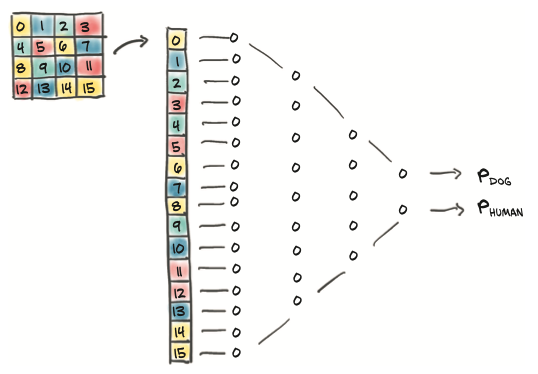

Using numpy, we can easily transform our data using the reshape function:

In [4]:
#Here we flatten the input (i.e., convert 2D images to 1D vectors)
X_train = X_train.reshape(X_train.shape[0], -1) 
X_test = X_test.reshape(X_test.shape[0], -1)

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).long()

X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).long()

num_classes = int(y_train.max().item() + 1)
num_inputs = X_train.shape[1]

Training machine learning models is typically a computationally expensive task. To speed up the training process, we will try to use a faster device than our cpu.

In [5]:

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():    
    device = torch.device("cuda")
else:
    device = torch.device("cpu")



### ***Exercise 1:*** Implement a Deep Neural Network

Now that we've loaded and prepared our data, define a MLP class that shall be used to encode our model:

In [6]:
class DNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(DNN, self).__init__()
        self.layers = nn.ModuleList()
        self.activations = nn.ModuleList()

        if len(hidden_sizes) == 0:
            self.layers.append(nn.Linear(input_size, num_classes))
        else:
            self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
            self.activations.append(nn.ReLU())        
        
            for i in range(len(hidden_sizes)-1):
                self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
                self.activations.append(nn.ReLU())

            self.layers.append(nn.Linear(hidden_sizes[-1], num_classes))
    
    def forward(self, x):
        #TODO: implement the forward pass
        out = x 
        for i in range(len(self.layers)):
            out = self.layers[i](out)
            if i < len(self.activations):
                out = self.activations[i](out)
        return out

We could have defined a method of the DNN class to train itself. But, through Pytorch, we can define a single method that trains both DNNs and CNNs. Let's see how:

In [ ]:
def fit(X_train, y_train, nn, criterion, optimizer, n_epochs, to_device=True, batch_size=32):
    #send everything to the device (ideally a GPU)
    if to_device:
        nn = nn.to(device)
        X_train = X_train.to(device)
        y_train = y_train.to(device)

    # Train the network
    loss_values = []
    for epoch in range(n_epochs):
        accu_loss = 0
        for i in range(0, X_train.size(0), batch_size):
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            # Forward pass
            outputs = nn(X_batch)
            loss = criterion(outputs, y_batch)
            accu_loss += loss.item()
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        #if (epoch+1) % 10 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, n_epochs, accu_loss))
        loss_values.append(accu_loss)

    return loss_values, nn.to("cpu")

### ***Exercise 2:*** The code below creates and trains a network instance. Test different parameters and assess the results.

In [ ]:
# Create the network, define criterion and optimizer
n_epochs = 10
BATCH_SIZE = 100
n_layers = 1

# Determine the number of classes
hidden_layer_sizes = ((num_inputs + num_classes) // 2,)*n_layers
dnn = DNN(input_size=num_inputs, hidden_sizes=hidden_layer_sizes, num_classes=num_classes)



#this criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class. 
#It expects the target to be class indices (not one-hot encoded)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(dnn.parameters(), lr=0.1)
dnn_loss_values, dnn = fit(X_train, y_train, dnn, criterion, optimizer, n_epochs, batch_size=BATCH_SIZE, to_device=False)


And finally we can evaluate our network's performance

In [ ]:

def evaluate_network(net, X, y, to_device=True):
    # Set the model to evaluation mode
    net.eval()
    if to_device:
        X = X.to(device)
        net = net.to(device)

    # Run the model on the test data
    with torch.no_grad():
        outputs = net(X)
        _, predicted = torch.max(outputs.data, 1)

    # Convert tensors to numpy arrays
    if to_device:
        predicted = predicted.to("cpu")
    predicted_np = predicted.numpy()
    test_target_np = y.numpy()

    # Compute confusion matrix and F1 score
    conf_mat = confusion_matrix(test_target_np, predicted_np)
    f1 = f1_score(test_target_np, predicted_np, average='weighted')

    print('Confusion Matrix:\n', conf_mat)
    print('F1 Score: ', f1)
    
print('Evaluating with the training data')
evaluate_network(dnn, X_train, y_train)

print('Evaluating with the test data')
evaluate_network(dnn, X_test, y_test)


### ***Are DNNs enough?***
Now that we've managed to solve the MNIST problem successfully, we can try to tackle a more complex problem. Let's focus on CIFAR-10. This problem is quite simillar to MNIST, in the sense that it is an image classification problem with 10 possible classes. However, the images are more complex, representing real life scenes instead of hand-written digits. The classes present in CIFAR-10 are: 

0 - airplane

1 - automobile

2 - bird

3 - cat

4 - deer

5 - dog

6 - frog

7 - horse

8 - ship

9 - truck

Let's start by loading the dataset and visualizing a set of samples:

Files already downloaded and verified
Files already downloaded and verified
<PIL.Image.Image image mode=RGB size=32x32 at 0x16C539790> 1
automobile
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


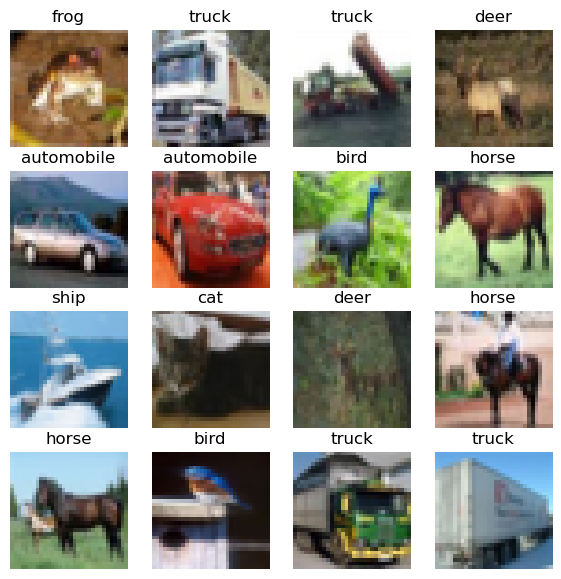

In [6]:


# Load the CIFAR-10 dataset and visualize some images
cifar10_trainset = datasets.CIFAR10(root='./data', train=True, download=True)
cifar10_testset = datasets.CIFAR10(root='./data', train=False, download=True)

img, label = cifar10_trainset[99]
print(img, label)
print(cifar10_trainset.classes[label])
print(cifar10_trainset.classes)

#As we can see, the sample is a PIL image, and the label is an integer. 
#We can visualize the image using matplotlib:
plt.figure(figsize=(7, 7))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(cifar10_trainset[i][0], cmap='gray')
    plt.title(cifar10_trainset.classes[cifar10_trainset[i][1]])
    plt.axis("off")


As we've seen, the samples are PIL images. In order to use them in our DNN, we need to convert them to Tensors. The easiest way to do it is actually reloading the datasets, defining the appropriate transform:

In [13]:
#We can also convert the PIL image to a PyTorch tensor using the torchvision.transforms.ToTensor transform:
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
print(img_t.shape)

#But it would be more convenient to apply the transform directly when loading the dataset.
#We can do this by passing the transform as an argument to the dataset constructor:
cifar10_trainset = datasets.CIFAR10(root='./data', train=True, download=False, transform=transforms.ToTensor())
cifar10_testset = datasets.CIFAR10(root='./data', train=False, download=False, transform=transforms.ToTensor())

#Now, the dataset will return PyTorch tensors instead of PIL images
#Also, the values of the image tensor are now floats (rather than integers)
#And they're in the range [0.0, 1.0] rather than [0, 255]
print(cifar10_trainset[99][0].shape, cifar10_trainset[99][0].dtype)



torch.Size([3, 32, 32])
torch.Size([3, 32, 32]) torch.float32


Now, note that the shape of the image tensor is [3, 32, 32] instead of [32, 32, 3]. This is because PyTorch stores the color channels first (i.e., in the form C × H × W) rather than last (H × W × C). This is a common convention in deep learning because it allows us to generalize the operations to N-dimensional tensors (i.e., it allows us to use gray-scale images as well as images with various color channels). We can however convert the tensor to the more common form using the permute method, which is particularly useful for visualizing the image:

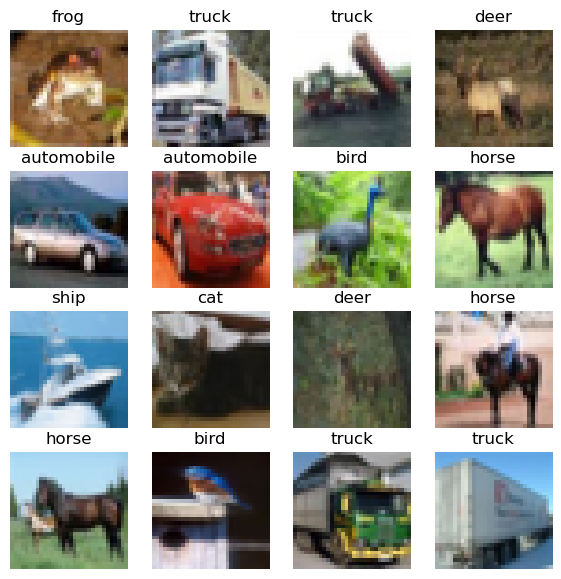

In [14]:

img_t, _ = cifar10_trainset[99]
img_t = img_t.permute(1, 2, 0)

#Even though the images are now tensors, they can still be visualized
#using the imshow function from matplotlib:
plt.figure(figsize=(7, 7))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(cifar10_trainset[i][0].permute(1,2,0))
    plt.title(cifar10_trainset.classes[cifar10_trainset[i][1]])
    plt.axis("off")

plt.show()


We'd like to start by using our MLP. In order to do it, we need to convert our data from 3D (RGB images) to 1D structures. Also, using wide interval of values ([0-255]) is bound to make the learning process harder. To make things easier, we can normalize our samples by dividing them by 255.

In [15]:

X_train = cifar10_trainset.data/255.0
y_train = cifar10_trainset.targets
X_test = cifar10_testset.data/255.0
y_test = cifar10_testset.targets

X_train_flattened = X_train.reshape(X_train.shape[0], -1) #Here we flatten the input (i.e., convert 2D images to 1D vectors)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

print(type(X_train_flattened), X_train_flattened.shape)

#We also convert the input and output to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_train = X_train.permute(0, 3, 1, 2)
X_test = torch.tensor(X_test, dtype=torch.float32)
X_test = X_test.permute(0, 3, 1, 2)

X_train_flattened = torch.tensor(X_train_flattened, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)#torch.int64)

X_test_flattened = torch.tensor(X_test_flattened, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)#torch.int64)

num_classes = int(y_train.max().item() + 1)
num_inputs = X_train_flattened.shape[1]


<class 'numpy.ndarray'> (50000, 3072)


Now that we have the data in the right format, we can define the network and train it. To do so, we will use the DNN class that we defined above:

In [16]:
# Create the network, define criterion and optimizer
n_epochs = 100
n_layers = 1

# Determine the number of classes
hidden_layer_sizes = ((num_inputs + num_classes) // 2,)*n_layers
dnn = DNN(input_size=num_inputs, hidden_sizes=hidden_layer_sizes, num_classes=num_classes)

criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(dnn.parameters(), lr=0.01)

dnn_loss_values, dnn = fit(X_train_flattened, y_train, dnn, criterion, optimizer, n_epochs, batch_size=BATCH_SIZE, to_device=False)


NameError: name 'DNN' is not defined

In [17]:
X_train_flattened = X_train_flattened.to("cpu")
dnn = dnn.to("cpu")

print('Evaluating with the training data')
evaluate_network(dnn, X_train_flattened, y_train, to_device=False)

print('Evaluating with the test data')
evaluate_network(dnn, X_test_flattened, y_test, to_device=False)

NameError: name 'dnn' is not defined

It seems that our DNN cannot cope with this problem... The trouble is that, unlike MNIST, this is a hard problem and DNNs tend to not work well using just the pixel values. This is partially due to the fact that using pixel values make the model sensible to translations, as the image below depicts:

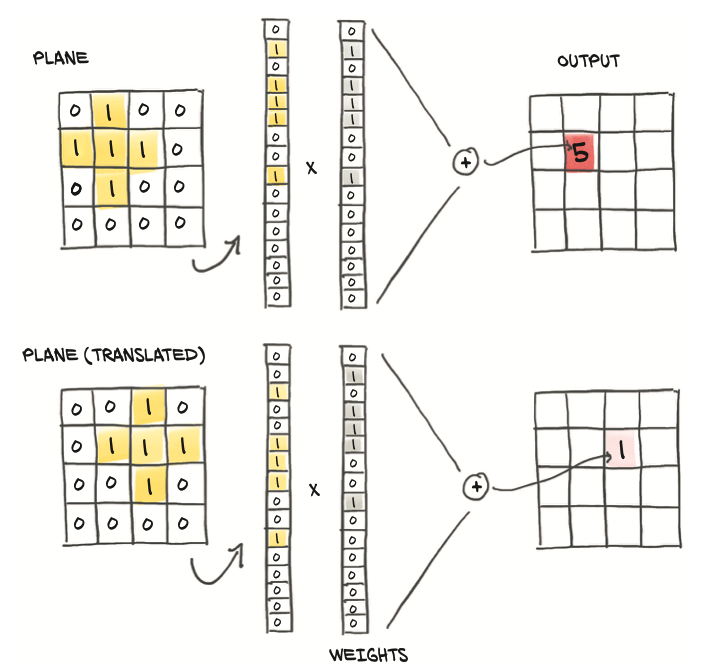

To solve this, you could venture into the real of feature engineering, where you'd apply existing methods to extract and select features from images. But that those features need to be tailored for each problem and they often tend to be sub-optimal (and they're also out of the scope of this class!!). So, let's enable your NNs to extract this features automatically. We can do so with CNNs!


### ***Convolution Neural Networks***

Lets recall some of the concepts discussed in the theoretical class. 

CNNs successively split images into smaller representations allowing them to identify different features to discriminate between image classes. 

Specifically a convolution is an operation on two objects that produces an outcome expressing how the shape of one is modified by the other. CNN uses this operations to automatically compute features on an input image producing **feature maps**, which will be smaller than original image. That is why sometimes CNN layers are referred to as 'feature extractors'. 
The figure below illustrates this operation.

<img src="cnnsfilters.gif">

In Pytorch, a 2-D convolution is performed by the Conv2D layer. We usually build CNNs as stacked alternated convolution and pooling layers, as you will see in the exercises below, but it is not mandatory.

The number of filters of the Conv2D is related to how "generic" the features it captures are. For instance, a Conv2D with 32 filters detects less features than a layer with 64 filters, which will capture more patterns.

**Pooling**

Convolutional layers are often followed by a pooling layer. The polling layer reduces the size of the feature map by removing redundant information. While convolutions consist in multiplication by some weights, pooling is typically the computation of a single value by taking the maximum or the average value of a region of the input. The figure bellow provides an example of the Max and Average Pooling.

<img src="pooling.png">


In Pytorch, the max pooling operation can be done by the max_pool2d layer, which returns the maximum values of rectangular regions of the inputs. These regions may either be defined by a width and a height values or by a single dimension, applying a square kernel.

**Activations**

Non-linear activation functions are commonly used in CNNs. This allows the layers to learn complex mapping functions from inputs to outputs faster efficiently than just summing values or using a linear function. One of the most popular activations Rectified Linear Unit, or ReLU, which simply returns the input value if higher than 0 or 0 otherwise.

**Padding**

As shown in the figure below, when convolving over an image, some pixels at the border of the images that are less convolved than the ones in the middle of the image, which means that some pixels will be more important than others, when they shouldn't.

<img src="no_padding_no_strides.gif">

To avoid this we can use **padding** which basically consists of adding dummy pixels to the image borders. The figure below illustrates a form of padding.

<div>
    <img src="full_padding_no_strides.gif" width="300">
</div>



**Dropout, Flatten and Dense**

After having the CNN extracting the features, you still need to make predictions, which is where the Dropout, Flatten and Dense layers come in. Dropout layers aim at reducing  overfitting by randomly "dropping" (i.e., ignoring) a percentage of neurons at each stage of training. 

Flatten's only job is to convert the outcome of the convolutions to a 1-D vector that one or more Dense layers (aka 'fully connected') can consume. The outcome of the final Dense layer is the probability distribution for each class

<img src="cnnfull.png">




To sum up, you input an image to your network (usually with multiple color channels), the convolution layers extract features from that image that are then classified by a fully connected layer. The loss function computed the classification error that is used by the training algorithm to adjust all the weights.

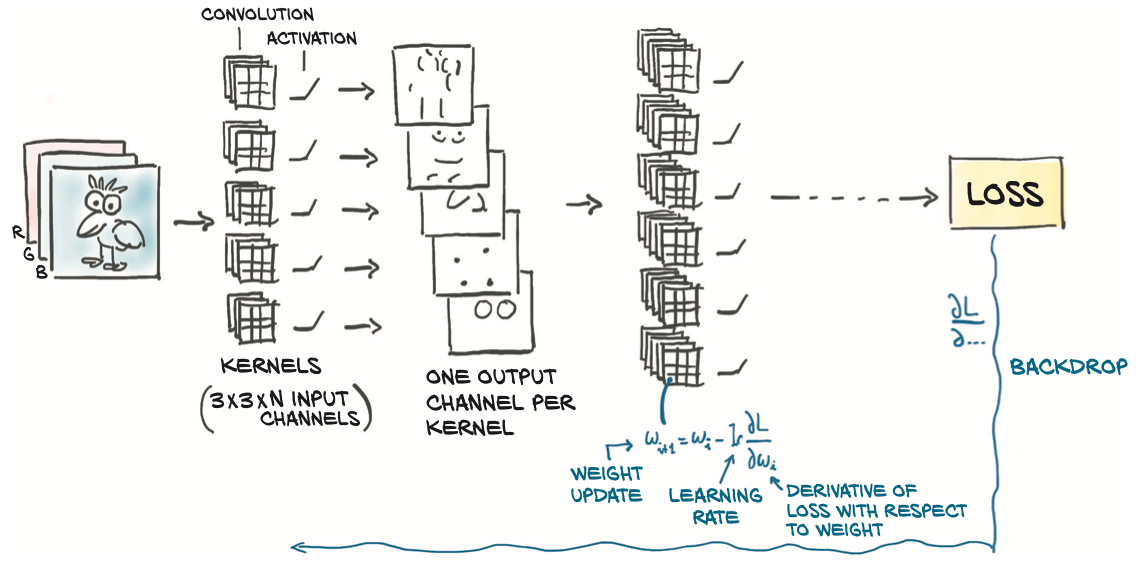

### Implementing a CNN
Now let's implement our network. Simillarly to our DNN class, it will inherit most properties from Pytorch's nn.Module class, redefining the __init__ and __forward__ functions. 

In [18]:

class CNN(nn.Module):
    def __init__(self, input_channels=3, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding = 1)
        
        #8x8x8=512 is the dimension of the tensor after the last convolution. 
        #It consists of 8 filters of size 8x8 (due to pooling)
        self.fc1 = nn.Linear(8*8*8, 32)
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x =  F.max_pool2d(F.relu(self.conv2(x)), 2)
        
        x = x.view(-1, self.fc1.in_features)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



### ***Exercise 3***: Train a CNN 
Simillarly to the DNN, we can now instantiate the CNN class and train our model. Complete the code below to do so, using the fit function defined above. Plot the loss values of the DNN and CNN to compare their performance.

In [19]:
#n_epochs = 50
cnn = CNN(3, 10)



plt.plot(dnn_loss_values, label='DNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: name 'dnn_loss_values' is not defined

Now let's evaluate the trained CNN using the same function that we defined for our DNN. Use the evaluate_network function to assess its performance in the train and test sets.

### ***Exercise 4***: Improve the Networks

Now that you've seen how to make DNNs and CNNs, its time to see how well you can do. Experiment with different architectures to see what is the best performance that you can get.

### References
[1] - Stevens, Eli, Luca Antiga, and Thomas Viehmann. Deep learning with PyTorch. Manning Publications, 2020.

[2] - https://github.com/vdumoulin/conv_arithmetic